# Video: Life Cycle Planning for Retirement

Retirement planning while depending on investment income can feel risky.
This video walks throuh the process of simulating a portfolio with withdrawals in a retirement to determine whether it is likely to last through retirement.

Script:
* Suppose a soon-to-be retiree is planning their retirement finances, and wants to make sure that their income requirements will be covered.
* How can they be confident that they have enough saved?

Script:
* Let's add a little bit more concrete detail.
* Assume that they have one million dollars saved and they expect to cover $60,000 per year from these investments.
* Based on family history, they are expecting to live for 30 more years.
* Do they have enough?
* That depends on what performance they expect from those investments.
* Let's consider a few different few scenarios and simulate whether their savings hold up.

In [ ]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

historical_prices_url = "https://raw.githubusercontent.com/bu-cds-omds/dx704-examples/refs/heads/main/data/prices-monthly.tsv"
historical_prices = pd.read_csv(historical_prices_url, sep="\t")
historical_prices = historical_prices.set_index("date")

historical_returns = historical_prices.pct_change().dropna()
estimated_returns = historical_returns.mean().rename("return")
estimated_variances = historical_returns.var()

estimated_covariance = historical_returns.cov()

In [ ]:
# min/max return range for efficient portfolios

n = len(estimated_returns)

x_minimum_risk = cp.Variable(n)

objective_minimum_risk = cp.Minimize(x_minimum_risk.T @ estimated_covariance.to_numpy() @ x_minimum_risk)
objective_minimum_risk

prob_minimum_risk = cp.Problem(objective_minimum_risk,
                               [0 <= x_minimum_risk,
                                cp.sum(x_minimum_risk) == 1])

covariance_minimum_risk = prob_minimum_risk.solve()
covariance_minimum_risk

estimated_return_minimum_risk = x_minimum_risk.value.T @ estimated_returns
estimated_return_minimum_risk

estimated_return_maximum_return = max(estimated_returns)

In [ ]:
ef_variances = []
ef_returns = []
ef_portfolios = []

for r in np.linspace(estimated_return_minimum_risk, max(estimated_returns), 1000):
    # create variables to optimize
    x_r = cp.Variable(n)

    # formulate linear program
    prob_r = cp.Problem(cp.Minimize(x_r.T @ estimated_covariance.to_numpy() @ x_r),
                        [0 <= x_r,
                         cp.sum(x_r) == 1,
                         x_r.T @ estimated_returns == r])
    ef_variances.append(prob_r.solve())
    ef_returns.append(r)
    ef_portfolios.append(x_r.value)

ef_portfolios = np.asarray(ef_portfolios)


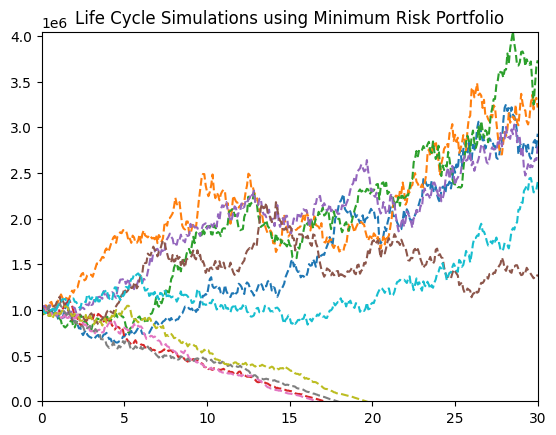

In [ ]:
initial_investment = 1_000_000
monthly_expense = 60_000 / 12

def simulate_lifecycle(portfolio_name, portfolio_return, portfolio_variance):
    np.random.seed(704_1)

    simulations = []
    while len(simulations) < 10:
        simulations.append([initial_investment])

        # simulate 30 years one month at a tie
        while len(simulations[-1]) < 30 * 12 + 1:
            simulations[-1].append(simulations[-1][-1] * (1 + np.random.normal(portfolio_return, np.sqrt(portfolio_variance))) - monthly_expense)

        plt.plot([i / 12 for i in range(len(simulations[-1]))], simulations[-1], linestyle="dashed")

    # plt.axhline(y=0)
    plt.title(f"Life Cycle Simulations using {portfolio_name} Portfolio")
    plt.xlim(0, 30)
    plt.ylim(0, min(10*initial_investment, np.max(simulations)))
    plt.show()

simulate_lifecycle("Minimum Risk", ef_returns[0], ef_variances[0])

Script:
* The chart above shows 10 simulations of the retirement scenario using the minimum risk portfolio.
* To be frank, they don't look good - note how the money runs out in some simulations.
* While tweaking this chart, the number of simulations where the money ran out was almost always between 3 and 5, or 30% to 50% of the simulations.
* We could run a lot more simulations to get a better bound on that failure rate, but that is already unacceptably high.
* The root of the problem is that this scenario withdraws \$5,000 from the portfolio, but the average gain from the initial \$1,000,000 is only \$5,364.
* There is hardly any margin to cover the withdrawal, and a little bad luck at the beginning will shrink the portfolio below its initial value.
* That will further reduce the margin, and may make the expected margin negative, at which point the portfolio is expected to keep shrinking.
* What if we pick a higher return portfolio instead?

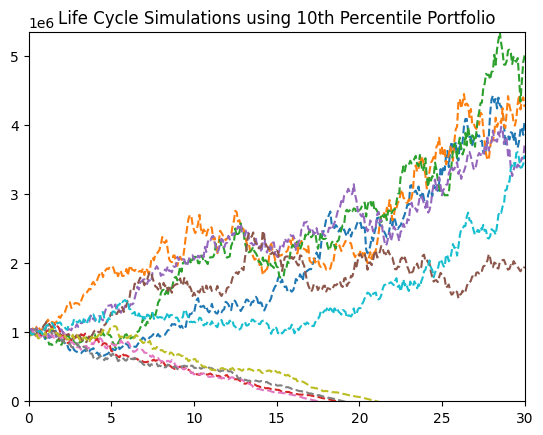

In [ ]:
simulate_lifecycle("10th Percentile", ef_returns[10], ef_variances[10])

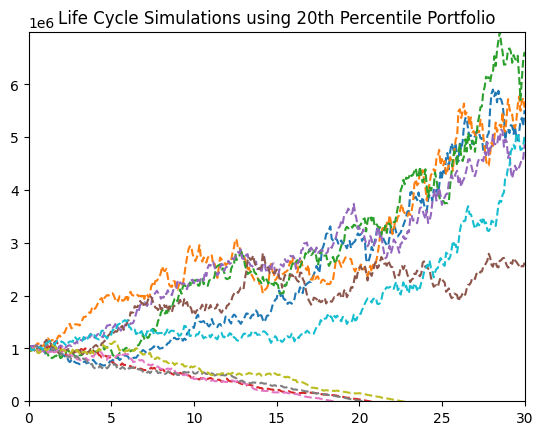

In [ ]:
simulate_lifecycle("20th Percentile", ef_returns[20], ef_variances[20])

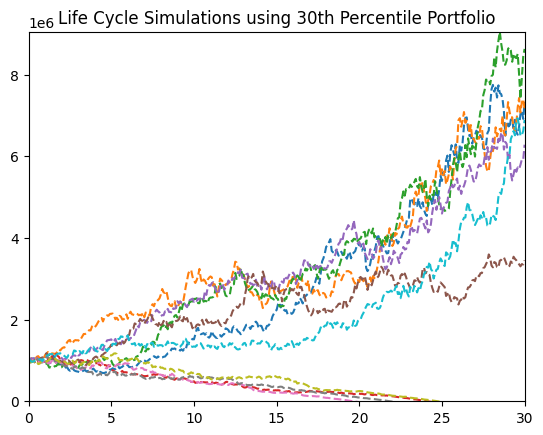

In [ ]:
simulate_lifecycle("30th Percentile", ef_returns[30], ef_variances[30])

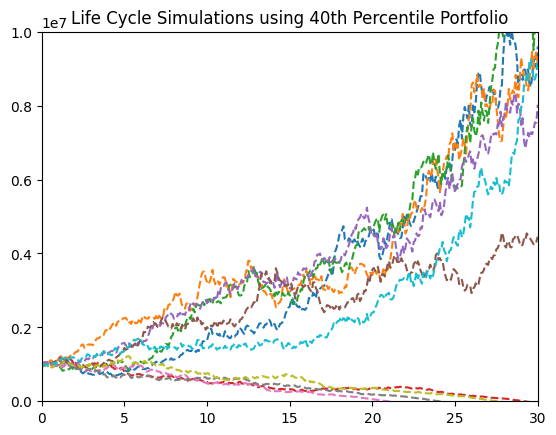

In [ ]:
simulate_lifecycle("40th Percentile", ef_returns[40], ef_variances[40])

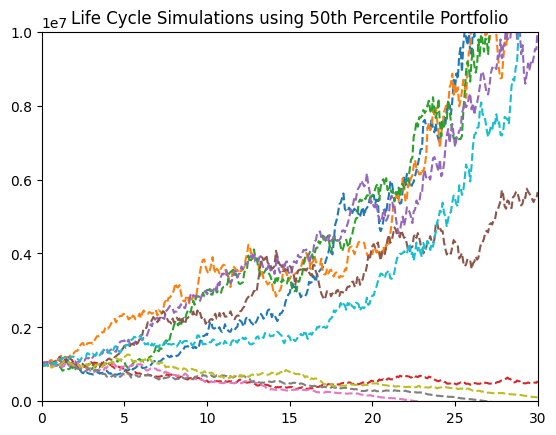

In [ ]:
simulate_lifecycle("50th Percentile", ef_returns[50], ef_variances[50])

Script:
* As higher return portfolios were used, the general trajectories improved, but every batch of ten simulations run so far showed at least one running out of money.
* So the verdict for retirement is not looking great unfortunately.
* Perhaps this was predictable - a common rule of thumb is to save up 30 times your annual expenses but this was less than 17 times.
* But by running this simulation, we could check quantitatively based on our actual plans and investments instead of winging it.